<a href="https://colab.research.google.com/github/AmirJlr/Molecular-Property-Prediction/blob/master/00-DLB_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [deep learning for molecules & materials](https://dmol.pub/)

## Graph Neural Networks

Historically, the biggest difficulty for machine learning with molecules was the choice and computation of "descriptors". Graph neural networks (GNNs) are a category of deep neural networks whose inputs are graphs and provide a way around the choice of descriptors. A GNN can take a molecule directly as input.


```
After completing this chapter, you should be able to :

  * Represent a molecule in a graph
  * Discuss and categorize common graph neural network architectures
  * Build a GNN and choose a read-out function for the type of labels
  * Distinguish between graph, edge, and node features
  * Formulate a GNN into edge-updates, node-updates, and aggregation steps
```

GNNs are specific layers that input a graph and output a graph. Before we dive too deep into them, we must first understand **how a graph is represented in a computer and how molecules are converted into graphs**.



## Representing a Graph

A graph $\mathbf{G}$ is a set of nodes $\mathbf{V}$ and edges $\mathbf{E}$. In our setting, node $i$ is defined by a vector $\vec{v}_i$, so that the set of nodes can be written as a rank 2 tensor.

The edges can be represented as an adjacency matrix $\mathbf{E}$, where if $e_{ij} = 1$ then nodes $i$ and $j$ are connected by an edge.

 In many fields, graphs are often immediately simplified to be directed and acyclic, which simplifies things.

 Molecules are instead undirected and have cycles (rings). Thus, our adjacency matrices are always symmetric $e_{ij} = e_{ji}$ because there is no concept of direction in chemical bonds. Often our edges themselves have features, so that $e_{ij}$ is itself a vector. Then the adjacency matrix becomes a rank 3 tensor. Examples of edge features might be **covalent bond ** order or distance between two nodes.

<figure>
   <img src='https://dmol.pub/_images/methanol.jpg' alt="depiction of methanol as lewis dot structure" width=400 />
   <figcaption>Methanol with atoms numbered so that we can convert it to a graph.</figcaption>
</figure>


Let's see how a graph can be constructed from a molecule. Consider methanol, shown in above figure. I've numbered the atoms so that we have an order for defining the nodes/edges. First, the node features. You can use anything for node features, but often we'll begin with one-hot encoded feature vectors:

| Node | C  | H  | O  |
|:-----|----|----|---:|
| 1    | 0  | 1  |  0 |
| 2    | 0  | 1  |  0 |
| 3    | 0  | 1  |  0 |
| 4    | 1  | 0  |  0 |
| 5    | 0  | 0  |  1 |
| 6    | 0  | 1  |  0 |

$\mathbf{V}$ will be the combined feature vectors of these nodes. The adjacency matrix $\mathbf{E}$ will look like:


|    | 1  | 2  | 3  | 4  | 5  | 6  |
|:---|----|----|----|----|----|---:|
| 1  | 0  | 0  | 0  | 1  | 0  |  0 |
| 2  | 0  | 0  | 0  | 1  | 0  |  0 |
| 3  | 0  | 0  | 0  | 1  | 0  |  0 |
| 4  | 1  | 1  | 1  | 0  | 1  |  0 |
| 5  | 0  | 0  | 0  | 1  | 0  |  1 |
| 6  | 0  | 0  | 0  | 0  | 1  |  0 |


Take a moment to understand these two. For example, notice that rows 1, 2, and 3 only have the 4th column as non-zero. That's because atoms 1-3 are bonded only to carbon (atom 4). Also, the diagonal is always 0 because atoms cannot be bonded with themselves.

**We'll now begin with a function which can convert a smiles string into this representation.**

In [1]:
### Install Packages :
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch_geometric
!pip install rdkit

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 18.4 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import pandas as pd
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw
import networkx as nx

In [4]:
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/main/data/curated-solubility-dataset.csv"
)
np.random.seed(0)
my_elements = {6: "C", 8: "O", 1: "H"}

In [7]:
soldata.head(3)

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782,202.661065


In [8]:
soldata.columns

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')

The cell below defines our function `smiles2graph`.

This creates one-hot node feature vectors for the element C, H, and O.

It also creates an adjacency tensor with one-hot bond order being the feature vector.

In [9]:
def smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

In [10]:
nodes, adj = smiles2graph("CO")
nodes

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

## A Graph Neural Network

A graph neural network (GNN) is a neural network with two defining attributes:

1. Its input is a graph
2. Its output is permutation equivariant

Graph permutation means re-ordering our nodes. In our methanol example above, we could have easily made the carbon be atom 1 instead of atom 4. Our new adjacency matrix would then be:

|    | 1  | 2  | 3  | 4  | 5  | 6  |
|:---|----|----|----|----|----|---:|
| 1  | 0  | 1  | 1  | 1  | 1  |  0 |
| 2  | 1  | 0  | 0  | 0  | 0  |  0 |
| 3  | 1  | 0  | 0  | 0  | 0  |  0 |
| 4  | 1  | 0  | 0  | 0  | 1  |  0 |
| 5  | 1  | 0  | 0  | 0  | 0  |  1 |
| 6  | 0  | 0  | 0  | 0  | 1  |  0 |


**A GNN is permutation equivariant if the output change the same way as these exchanges**.

If you are trying to model a per-atom quantity like partial charge or chemical shift, this is obviously essential. If you change the order of atoms input, you would expect the order of their partial charges to similarly change.

Often we want to model a **whole-molecule property (Graph-Level)**, like solubility or energy.

This should be **invariant** to changing the order of the atoms. To make an equivariant model invariant, we use read-outs (defined below). See [`data`](https://dmol.pub/dl/data.html) for a  more detailed discussion of equivariance.

### A simple GNN

We will often mention a GNN when we really mean a layer from a GNN. Most GNNs implement a specific layer that can deal with graphs, and so usually we are only concerned with this layer. Let's see an example of a simple layer for a GNN:

\begin{equation}
f_k = \sigma\left( \sum_i \sum_j v_{ij}w_{jk}  \right)
\end{equation}

This equation shows that **we first multiply every node ($v_{ij}$) feature by trainable weights $w_{jk}$, sum over all node features, and then apply an activation.** This will yield a single feature vector for the graph.

Is this equation permutation invariant? Yes, because the node index in our expression is index $i$ which can be re-ordered without affecting the output.

Let's see an example that is similar, but not permutation invariant:

\begin{equation}
f_k = \sigma\left( \sum_i v_{ij}w_{ik}  \right)
\end{equation}

This is a small change. We have one weight vector per node now. This makes the trainable weights depend on the ordering of the nodes. Then if we swap the node ordering, our weights will no longer align. So if we were to input two methanol molecules, which should have the same output, but we switched two atom numbers, we would get different answers. These simple examples differ from real GNNs in two important ways: (i) they give a single feature vector output, which throws away per-node information, and (ii) they do not use the adjacency matrix. Let's see a real GNN that has these properties while maintaining permutation invariance --- or equivariance (swapping inputs swaps outputs the same way).

## Kipf & Welling GCN

One of the first popular GNNs was the Kipf & Welling graph convolutional network (GCN) {cite}`kipf2016semi`. Although some people consider GCNs to be a broad class of GNNs, we'll use GCNs to refer specifically the Kipf & Welling GCN.
Thomas Kipf has written an [excellent article introducing the GCN](https://tkipf.github.io/graph-convolutional-networks/).

The input to a GCN layer is $\mathbf{V}$, $\mathbf{E}$ and it outputs an updated $\mathbf{V}'$. Each node feature vector is updated. The way it updates a node feature vector is by averaging the feature vectors of its neighbors, as determined by $\mathbf{E}$. The choice of averaging over neighbors is what makes a GCN layer permutation equivariant. Averaging over neighbors is not trainable, so we must add trainable parameters. We multiply the neighbor features by a trainable matrix before the averaging, which gives the GCN the ability to learn. In Einstein notation, this process is:

$$
v_{il} = \sigma\left(\frac{1}{d_i}e_{ij}v_{jk}w_{kl}\right)
$$ (gcn)

where $i$ is the node we're considering, $j$ is the neighbor index, $k$ is the node input feature, $l$ is the output node feature, $d_i$ is the degree of node i (which makes it an average instead of sum), $e_{ij}$ isolates neighbors so that all non-neighbor $v_{jk}$s are zero, $\sigma$ is our activation, and $w_{lk}$ is the trainable weights. This equation is a mouthful, but it truly just is the average over neighbors with a trainable matrix thrown in. One common modification is to make all nodes neighbors of themselves. This is so that the output node features $v_{il}$ depends on the input features $v_{ik}$. We do not need to change our equation, just make the adjacency matrix have $1$s on the diagonal instead of $0$ by adding the identity matrix during pre-processing.

Building understanding about the GCN is important for understanding other GNNs.

**You can view the GCN layer as a way to "communicate" between a node and its neighbors. The output for node $i$ will depend only on its immediate neighbors.**

For chemistry, this is not satisfactory.
You can stack multiple layers though.

**If you have two layers, the output for node $i$ will include information about node $i$'s neighbors' neighbors.**

Another important detail to understand in GCNs is that the averaging procedure accomplishes two goals:
- (i) it gives permutation equivariance by removing the effect of neighbor order

- (ii) it prevents a change in magnitude in node features.


A sum would accomplish (i) but would cause the magnitude of the node features to grow after each layer. Of course, you could ad-hoc put a batch normalization layer after each GCN layer to keep output magnitudes stable but averaging is easy.

<figure>
   <img src='https://dmol.pub/_images/gnn_11_0.png' alt="depiction of methanol as lewis dot structure" width=400 />
   <figcaption>
   Intermediate step of the graph convolution layer. The 3D vectors are the node features and start as one-hot, so a [1.00, 0.00, 0.00] means hydrogen. The center node will be updated by averaging its neighbors features.
   </figcaption>
</figure>




<figure>
   <img src='https://dmol.pub/_images/gcn.gif' alt="animation of the graph convolution layer operation" width=600 />
   <figcaption>
    Animation of the graph convolution layer operation. The left is input, right is output node features. Note that two layers are shown (see title change). As the animation plays out, you can see how the information about the atoms propagates through the molecule via the averaging over neigbhors. So the oxygen goes from being just an oxygen, to an oxygen bonded to C and H, to an oxygen bonded to an H and CH3. The colors just reflect the same information in the numerical values.
   </figcaption>
</figure>

### GCN Implementation

Let's now create a tensor implementation of the GCN. We'll skip the activation and trainable weights for now.
We must first compute our rank 2 adjacency matrix. The `smiles2graph` code above computes an adjacency tensor with feature vectors. We can fix that with a simple reduction and add the identity at the same time


In [13]:
nodes, adj = smiles2graph("CO")
adj_mat = np.sum(adj, axis=-1) + np.eye(adj.shape[0])
adj_mat

array([[1., 1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1.]])

To compute degree of each node, we can do another reduction:

In [14]:
degree = np.sum(adj_mat, axis=-1)
degree

array([5., 3., 2., 2., 2., 2.])

Now we can put all these pieces together into the Einstein equation

In [15]:
print(nodes[0])
# note to divide by degree, make the input 1 / degree
new_nodes = np.einsum("i,ij,jk->ik", 1 / degree, adj_mat, nodes)
print(new_nodes[0])

[1. 0. 0.]
[0.2 0.2 0.6]


To now implement this as a layer in Keras, we must put this code above into a new Layer subclass. The code is relatively straightforward, but you can read-up on the function names and Layer class in [this tutorial](https://keras.io/guides/making_new_layers_and_models_via_subclassing/).

The three main changes are that we create trainable parameters `self.w` and use them in the {obj}`tf.einsum`, we use an activation `self.activation`, and we output both our new node features and the adjacency matrix.

The reason to output the adjacency matrix is so that we can stack multiple GCN layers without having to pass the adjacency matrix each time.

In [16]:
class GCNLayer(tf.keras.layers.Layer):
    """Implementation of GCN as layer"""

    def __init__(self, activation=None, **kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]), name="w")

    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj

A lot of the code above is Keras/TF specific and getting the variables to the right place. There are really only two key lines here. The first is to compute the degree by summing over the columns of the adjacency matrix:

```python
degree = tf.reduce_sum(adj, axis=-1)
```

The second key line is to do the GCN equation {eq}`gcn` (without the activation)

```python
new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
```

We can now try our layer:

In [17]:
gcnlayer = GCNLayer("relu")
# we insert a batch axis here
gcnlayer((nodes[np.newaxis, ...], adj_mat[np.newaxis, ...]))

(<tf.Tensor: shape=(1, 6, 3), dtype=float32, numpy=
 array([[[0.05163727, 0.12657475, 0.34411106],
         [0.00952625, 0.12251227, 0.        ],
         [0.        , 0.        , 0.09999692],
         [0.        , 0.        , 0.09999692],
         [0.        , 0.        , 0.09999692],
         [0.16327226, 0.32437623, 0.26896775]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
 array([[[1., 1., 1., 1., 1., 0.],
         [1., 1., 0., 0., 0., 1.],
         [1., 0., 1., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 1.]]], dtype=float32)>)

It outputs (1) the new node features and (2) the adjacency matrix. Let's make sure we can stack these and apply the GCN multiple times

In [18]:
x = (nodes[np.newaxis, ...], adj_mat[np.newaxis, ...])
for i in range(2):
    x = gcnlayer(x)
print(x)

(<tf.Tensor: shape=(1, 6, 3), dtype=float32, numpy=
array([[[0.02169251, 0.03936034, 0.09485521],
        [0.04164504, 0.10472553, 0.0572543 ],
        [0.03120009, 0.05486057, 0.16984622],
        [0.03120009, 0.05486057, 0.16984622],
        [0.03120009, 0.05486057, 0.16984622],
        [0.03700748, 0.10886094, 0.        ]]], dtype=float32)>, <tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[1., 1., 1., 1., 1., 0.],
        [1., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1.]]], dtype=float32)>)


It works! Why do we see zeros though? Probably because we had negative numbers that were removed by our ReLU activation. This will be solved by training and increasing our dimension number.

## Solubility Example

We'll now revisit predicting solubility with GCNs.
**Remember before that we used the features included with the dataset**.

Now **we can use the molecular structures directly**.

**Our GCN layer outputs node-level features. To predict solubility, we need to get a graph-level feature.**

We'll see later how to be more sophisticated in this process, but for now let's just **take the average over all node features after our GCN layers.**

**This is simple, permutation invariant, and gets us from node-level to graph level.**

Here's an implementation of this :

In [19]:
class GRLayer(tf.keras.layers.Layer):
    """A GNN layer that computes average over all node features"""

    def __init__(self, name="GRLayer", **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        nodes, adj = inputs
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction

The key line in that code is to just to compute the mean over the nodes (`axis=1`):

```python
reduction = tf.reduce_mean(nodes, axis=1)
```


To complete our deep solubility predictor, we can add some dense layers and make sure we have a single-output without activation since we're doing regression. Note this model is defined using the [Keras functional API](https://keras.io/guides/functional_api/) which is necessary when you have multiple inputs.

In [22]:
ninput = tf.keras.Input(
    (
        None,
        100,
    )
)
ainput = tf.keras.Input(
    (
        None,
        None,
    )
)
# GCN block
x = GCNLayer("relu")([ninput, ainput])
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)

# reduce to graph features - Global Pooling
x = GRLayer()(x)
# standard layers (the readout)
x = tf.keras.layers.Dense(16, "tanh")(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)

**where does the 100 come from? Well, this dataset has lots of elements so we cannot use our size 3 one-hot encodings because we'll have more than 3 unique elements.**

We previously only had C, H and O. This is a good time to update our `smiles2graph` function to deal with this.

In [23]:
def gen_smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, 100))
    for i in m.GetAtoms():
        nodes[i.GetIdx(), i.GetAtomicNum()] = 1

    adj = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
    adj += np.eye(N)
    return nodes, adj

In [24]:
nodes, adj = gen_smiles2graph("CO")
model((nodes[np.newaxis], adj_mat[np.newaxis]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.03079825]], dtype=float32)>

```{margin}
We have switched from adjacency tensor to matrix only because a GCN cannot use edge features. Other architectures though can.
```
It outputs one number! That's always nice to have. Now we need to do some work to get a trainable dataset. Our dataset is a little bit complex because our features are tuples of tensors($\mathbf{V}, \mathbf{E}$) so that our dataset is a tuple of tuples: $\left((\mathbf{V}, \mathbf{E}), y\right)$. We use a **generator**, which is just a python function that can return multiple times. Our function returns once for every training example. Then we have to pass it to the `from_generator` {obj}`tf.data.Dataset` constructor which requires explicit declaration of the shapes of these examples.

In [25]:
def example():
    for i in range(len(soldata)):
        graph = gen_smiles2graph(soldata.SMILES[i])
        sol = soldata.Solubility[i]
        yield graph, sol


data = tf.data.Dataset.from_generator(
    example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, 100]), tf.TensorShape([None, None])),
        tf.TensorShape([]),
    ),
)

Whew, that's a lot. Now we can do our usual splitting of the dataset.

In [26]:
test_data = data.take(200)
val_data = data.skip(200).take(200)
train_data = data.skip(400)

And finally, time to train.

In [27]:
model.compile("adam", loss="mean_squared_error")
result = model.fit(train_data.batch(1), validation_data=val_data.batch(1), epochs=10)

Epoch 1/10


[10:42:02] WARNING: not removing hydrogen atom without neighbors


     55/Unknown - 3s 12ms/step - loss: 5.8676

[10:42:03] WARNING: not removing hydrogen atom without neighbors
[10:42:03] WARNING: not removing hydrogen atom without neighbors


    247/Unknown - 5s 12ms/step - loss: 3.0248

[10:42:05] WARNING: not removing hydrogen atom without neighbors


    312/Unknown - 6s 12ms/step - loss: 2.9083

[10:42:06] WARNING: not removing hydrogen atom without neighbors


    406/Unknown - 7s 13ms/step - loss: 2.5579

[10:42:08] WARNING: not removing hydrogen atom without neighbors


    469/Unknown - 8s 13ms/step - loss: 2.6059

[10:42:09] WARNING: not removing hydrogen atom without neighbors


    524/Unknown - 9s 13ms/step - loss: 2.5809

[10:42:09] WARNING: not removing hydrogen atom without neighbors
[10:42:09] WARNING: not removing hydrogen atom without neighbors


    584/Unknown - 10s 13ms/step - loss: 2.4426

[10:42:10] WARNING: not removing hydrogen atom without neighbors
[10:42:10] WARNING: not removing hydrogen atom without neighbors


    731/Unknown - 12s 13ms/step - loss: 2.5398

[10:42:12] WARNING: not removing hydrogen atom without neighbors


   1212/Unknown - 17s 12ms/step - loss: 2.6881

[10:42:17] WARNING: not removing hydrogen atom without neighbors
[10:42:17] WARNING: not removing hydrogen atom without neighbors
[10:42:17] WARNING: not removing hydrogen atom without neighbors
[10:42:17] WARNING: not removing hydrogen atom without neighbors


   1295/Unknown - 17s 12ms/step - loss: 2.5755

[10:42:17] WARNING: not removing hydrogen atom without neighbors
[10:42:18] WARNING: not removing hydrogen atom without neighbors


   1342/Unknown - 17s 11ms/step - loss: 3.6090

[10:42:18] WARNING: not removing hydrogen atom without neighbors
[10:42:18] WARNING: not removing hydrogen atom without neighbors


   1392/Unknown - 18s 11ms/step - loss: 3.6537

[10:42:18] WARNING: not removing hydrogen atom without neighbors


   1438/Unknown - 18s 11ms/step - loss: 3.5758

[10:42:18] WARNING: not removing hydrogen atom without neighbors


   1574/Unknown - 19s 11ms/step - loss: 3.5348

[10:42:19] WARNING: not removing hydrogen atom without neighbors


   1596/Unknown - 19s 11ms/step - loss: 3.5053

[10:42:20] WARNING: not removing hydrogen atom without neighbors


   1632/Unknown - 20s 11ms/step - loss: 3.4427

[10:42:20] WARNING: not removing hydrogen atom without neighbors


   1711/Unknown - 20s 11ms/step - loss: 3.3224

[10:42:21] WARNING: not removing hydrogen atom without neighbors
[10:42:21] WARNING: not removing hydrogen atom without neighbors


   1825/Unknown - 21s 10ms/step - loss: 3.1600

[10:42:22] WARNING: not removing hydrogen atom without neighbors
[10:42:22] WARNING: not removing hydrogen atom without neighbors
[10:42:22] WARNING: not removing hydrogen atom without neighbors
[10:42:22] WARNING: not removing hydrogen atom without neighbors
[10:42:22] WARNING: not removing hydrogen atom without neighbors


   1859/Unknown - 21s 10ms/step - loss: 3.1212

[10:42:22] WARNING: not removing hydrogen atom without neighbors


   1929/Unknown - 22s 10ms/step - loss: 3.0388

[10:42:22] WARNING: not removing hydrogen atom without neighbors
[10:42:22] WARNING: not removing hydrogen atom without neighbors


   2063/Unknown - 23s 10ms/step - loss: 2.8970

[10:42:23] WARNING: not removing hydrogen atom without neighbors
[10:42:23] WARNING: not removing hydrogen atom without neighbors
[10:42:23] WARNING: not removing hydrogen atom without neighbors
[10:42:23] WARNING: not removing hydrogen atom without neighbors


   2204/Unknown - 23s 10ms/step - loss: 2.7795

[10:42:24] WARNING: not removing hydrogen atom without neighbors
[10:42:24] WARNING: not removing hydrogen atom without neighbors
[10:42:24] WARNING: not removing hydrogen atom without neighbors


   2320/Unknown - 24s 9ms/step - loss: 2.6661

[10:42:24] WARNING: not removing hydrogen atom without neighbors


   2384/Unknown - 24s 9ms/step - loss: 2.6325

[10:42:25] WARNING: not removing hydrogen atom without neighbors


   2606/Unknown - 26s 9ms/step - loss: 2.4612

[10:42:26] WARNING: not removing hydrogen atom without neighbors
[10:42:26] WARNING: not removing hydrogen atom without neighbors


   2759/Unknown - 27s 9ms/step - loss: 2.5958

[10:42:27] WARNING: not removing hydrogen atom without neighbors
[10:42:27] WARNING: not removing hydrogen atom without neighbors


   2798/Unknown - 27s 9ms/step - loss: 2.5672

[10:42:27] WARNING: not removing hydrogen atom without neighbors
[10:42:27] WARNING: not removing hydrogen atom without neighbors


   2906/Unknown - 27s 9ms/step - loss: 2.5489

[10:42:28] WARNING: not removing hydrogen atom without neighbors
[10:42:28] WARNING: not removing hydrogen atom without neighbors
[10:42:28] WARNING: not removing hydrogen atom without neighbors


   3253/Unknown - 30s 8ms/step - loss: 2.5092

[10:42:30] WARNING: not removing hydrogen atom without neighbors


   3284/Unknown - 30s 8ms/step - loss: 2.7444

[10:42:30] WARNING: not removing hydrogen atom without neighbors


   3365/Unknown - 30s 8ms/step - loss: 2.8936

[10:42:31] WARNING: not removing hydrogen atom without neighbors


   3773/Unknown - 34s 8ms/step - loss: 2.9400

[10:42:34] WARNING: not removing hydrogen atom without neighbors
[10:42:34] WARNING: not removing hydrogen atom without neighbors
[10:42:34] WARNING: not removing hydrogen atom without neighbors


   4024/Unknown - 35s 8ms/step - loss: 2.9678

[10:42:36] WARNING: not removing hydrogen atom without neighbors


   4558/Unknown - 38s 8ms/step - loss: 2.9317

[10:42:39] WARNING: not removing hydrogen atom without neighbors


   5086/Unknown - 41s 8ms/step - loss: 2.8412

[10:42:42] WARNING: not removing hydrogen atom without neighbors


   5359/Unknown - 43s 8ms/step - loss: 2.8112

[10:42:43] WARNING: not removing hydrogen atom without neighbors


   5834/Unknown - 47s 8ms/step - loss: 2.8112

[10:42:47] WARNING: not removing hydrogen atom without neighbors
[10:42:47] WARNING: not removing hydrogen atom without neighbors


   9577/Unknown - 69s 7ms/step - loss: 2.4043

[10:43:11] WARNING: not removing hydrogen atom without neighbors


9582/9582 [==============================] - 72s 7ms/step - loss: 2.4034 - val_loss: 2.9778
Epoch 2/10
  10/9582 [..............................] - ETA: 54s - loss: 3.3482    

[10:43:24] WARNING: not removing hydrogen atom without neighbors


  76/9582 [..............................] - ETA: 55s - loss: 2.4384

[10:43:25] WARNING: not removing hydrogen atom without neighbors
[10:43:25] WARNING: not removing hydrogen atom without neighbors


 265/9582 [..............................] - ETA: 54s - loss: 2.3141

[10:43:26] WARNING: not removing hydrogen atom without neighbors


 327/9582 [>.............................] - ETA: 53s - loss: 2.2459

[10:43:26] WARNING: not removing hydrogen atom without neighbors


 432/9582 [>.............................] - ETA: 52s - loss: 2.1247

[10:43:27] WARNING: not removing hydrogen atom without neighbors


 484/9582 [>.............................] - ETA: 52s - loss: 2.1372

[10:43:27] WARNING: not removing hydrogen atom without neighbors


 537/9582 [>.............................] - ETA: 52s - loss: 2.1220

[10:43:27] WARNING: not removing hydrogen atom without neighbors
[10:43:27] WARNING: not removing hydrogen atom without neighbors


 602/9582 [>.............................] - ETA: 51s - loss: 2.0632

[10:43:28] WARNING: not removing hydrogen atom without neighbors
[10:43:28] WARNING: not removing hydrogen atom without neighbors


 750/9582 [=>............................] - ETA: 50s - loss: 2.2217

[10:43:29] WARNING: not removing hydrogen atom without neighbors


1206/9582 [==>...........................] - ETA: 51s - loss: 2.2366

[10:43:32] WARNING: not removing hydrogen atom without neighbors
[10:43:32] WARNING: not removing hydrogen atom without neighbors
[10:43:32] WARNING: not removing hydrogen atom without neighbors
[10:43:32] WARNING: not removing hydrogen atom without neighbors


1290/9582 [===>..........................] - ETA: 52s - loss: 2.1175

[10:43:32] WARNING: not removing hydrogen atom without neighbors
[10:43:33] WARNING: not removing hydrogen atom without neighbors


1340/9582 [===>..........................] - ETA: 51s - loss: 2.6295

[10:43:33] WARNING: not removing hydrogen atom without neighbors
[10:43:33] WARNING: not removing hydrogen atom without neighbors


1397/9582 [===>..........................] - ETA: 51s - loss: 2.6061

[10:43:33] WARNING: not removing hydrogen atom without neighbors


1434/9582 [===>..........................] - ETA: 51s - loss: 2.5690

[10:43:33] WARNING: not removing hydrogen atom without neighbors


1576/9582 [===>..........................] - ETA: 52s - loss: 2.5543

[10:43:35] WARNING: not removing hydrogen atom without neighbors


1599/9582 [====>.........................] - ETA: 52s - loss: 2.5312

[10:43:35] WARNING: not removing hydrogen atom without neighbors


1629/9582 [====>.........................] - ETA: 53s - loss: 2.4947

[10:43:35] WARNING: not removing hydrogen atom without neighbors


1711/9582 [====>.........................] - ETA: 53s - loss: 2.4237

[10:43:36] WARNING: not removing hydrogen atom without neighbors
[10:43:36] WARNING: not removing hydrogen atom without neighbors


1824/9582 [====>.........................] - ETA: 52s - loss: 2.3186

[10:43:37] WARNING: not removing hydrogen atom without neighbors
[10:43:37] WARNING: not removing hydrogen atom without neighbors
[10:43:37] WARNING: not removing hydrogen atom without neighbors
[10:43:37] WARNING: not removing hydrogen atom without neighbors


1861/9582 [====>.........................] - ETA: 51s - loss: 2.2933

[10:43:37] WARNING: not removing hydrogen atom without neighbors
[10:43:37] WARNING: not removing hydrogen atom without neighbors


1924/9582 [=====>........................] - ETA: 51s - loss: 2.2477

[10:43:37] WARNING: not removing hydrogen atom without neighbors
[10:43:37] WARNING: not removing hydrogen atom without neighbors


2067/9582 [=====>........................] - ETA: 49s - loss: 2.1444

[10:43:38] WARNING: not removing hydrogen atom without neighbors
[10:43:38] WARNING: not removing hydrogen atom without neighbors
[10:43:38] WARNING: not removing hydrogen atom without neighbors
[10:43:38] WARNING: not removing hydrogen atom without neighbors


2208/9582 [=====>........................] - ETA: 48s - loss: 2.0713

[10:43:39] WARNING: not removing hydrogen atom without neighbors
[10:43:39] WARNING: not removing hydrogen atom without neighbors
[10:43:39] WARNING: not removing hydrogen atom without neighbors


2323/9582 [======>.......................] - ETA: 47s - loss: 1.9970

[10:43:39] WARNING: not removing hydrogen atom without neighbors


2381/9582 [======>.......................] - ETA: 46s - loss: 2.0053

[10:43:40] WARNING: not removing hydrogen atom without neighbors


2608/9582 [=======>......................] - ETA: 44s - loss: 1.8795

[10:43:41] WARNING: not removing hydrogen atom without neighbors
[10:43:41] WARNING: not removing hydrogen atom without neighbors


2760/9582 [=======>......................] - ETA: 43s - loss: 2.0313

[10:43:42] WARNING: not removing hydrogen atom without neighbors
[10:43:42] WARNING: not removing hydrogen atom without neighbors


2806/9582 [=======>......................] - ETA: 43s - loss: 2.0071

[10:43:42] WARNING: not removing hydrogen atom without neighbors
[10:43:42] WARNING: not removing hydrogen atom without neighbors


2909/9582 [========>.....................] - ETA: 42s - loss: 2.0155

[10:43:43] WARNING: not removing hydrogen atom without neighbors
[10:43:43] WARNING: not removing hydrogen atom without neighbors
[10:43:43] WARNING: not removing hydrogen atom without neighbors


3252/9582 [=========>....................] - ETA: 40s - loss: 1.9901

[10:43:45] WARNING: not removing hydrogen atom without neighbors
[10:43:45] WARNING: not removing hydrogen atom without neighbors


3360/9582 [=========>....................] - ETA: 39s - loss: 2.2524

[10:43:46] WARNING: not removing hydrogen atom without neighbors


3784/9582 [==========>...................] - ETA: 37s - loss: 2.2780

[10:43:49] WARNING: not removing hydrogen atom without neighbors
[10:43:49] WARNING: not removing hydrogen atom without neighbors
[10:43:49] WARNING: not removing hydrogen atom without neighbors


4030/9582 [===========>..................] - ETA: 35s - loss: 2.2891

[10:43:50] WARNING: not removing hydrogen atom without neighbors


4537/9582 [=============>................] - ETA: 32s - loss: 2.2752

[10:43:53] WARNING: not removing hydrogen atom without neighbors


5086/9582 [==============>...............] - ETA: 28s - loss: 2.2001

[10:43:56] WARNING: not removing hydrogen atom without neighbors


5361/9582 [===============>..............] - ETA: 26s - loss: 2.1834

[10:43:58] WARNING: not removing hydrogen atom without neighbors


5830/9582 [=================>............] - ETA: 24s - loss: 2.1652

[10:44:02] WARNING: not removing hydrogen atom without neighbors
[10:44:02] WARNING: not removing hydrogen atom without neighbors


9580/9582 [============================>.] - ETA: 0s - loss: 1.9411

[10:44:26] WARNING: not removing hydrogen atom without neighbors


9582/9582 [==============================] - 63s 7ms/step - loss: 1.9408 - val_loss: 2.4718
Epoch 3/10
  10/9582 [..............................] - ETA: 59s - loss: 2.3173    

[10:44:46] WARNING: not removing hydrogen atom without neighbors


  66/9582 [..............................] - ETA: 1:01 - loss: 2.1150

[10:44:47] WARNING: not removing hydrogen atom without neighbors
[10:44:47] WARNING: not removing hydrogen atom without neighbors


 271/9582 [..............................] - ETA: 54s - loss: 1.7960

[10:44:48] WARNING: not removing hydrogen atom without neighbors


 316/9582 [..............................] - ETA: 55s - loss: 1.8094

[10:44:48] WARNING: not removing hydrogen atom without neighbors


 414/9582 [>.............................] - ETA: 1:03 - loss: 1.7309

[10:44:49] WARNING: not removing hydrogen atom without neighbors


 471/9582 [>.............................] - ETA: 1:07 - loss: 1.8510

[10:44:50] WARNING: not removing hydrogen atom without neighbors


 527/9582 [>.............................] - ETA: 1:09 - loss: 1.8435

[10:44:50] WARNING: not removing hydrogen atom without neighbors
[10:44:50] WARNING: not removing hydrogen atom without neighbors


 598/9582 [>.............................] - ETA: 1:09 - loss: 1.7795

[10:44:51] WARNING: not removing hydrogen atom without neighbors
[10:44:51] WARNING: not removing hydrogen atom without neighbors


 752/9582 [=>............................] - ETA: 1:04 - loss: 1.9605

[10:44:52] WARNING: not removing hydrogen atom without neighbors


1208/9582 [==>...........................] - ETA: 59s - loss: 1.9863

[10:44:55] WARNING: not removing hydrogen atom without neighbors
[10:44:55] WARNING: not removing hydrogen atom without neighbors
[10:44:55] WARNING: not removing hydrogen atom without neighbors
[10:44:55] WARNING: not removing hydrogen atom without neighbors


1296/9582 [===>..........................] - ETA: 59s - loss: 1.8888

[10:44:55] WARNING: not removing hydrogen atom without neighbors
[10:44:56] WARNING: not removing hydrogen atom without neighbors


1346/9582 [===>..........................] - ETA: 58s - loss: 2.2472

[10:44:56] WARNING: not removing hydrogen atom without neighbors
[10:44:56] WARNING: not removing hydrogen atom without neighbors


1393/9582 [===>..........................] - ETA: 57s - loss: 2.2149

[10:44:56] WARNING: not removing hydrogen atom without neighbors


1437/9582 [===>..........................] - ETA: 57s - loss: 2.1806

[10:44:56] WARNING: not removing hydrogen atom without neighbors


1582/9582 [===>..........................] - ETA: 54s - loss: 2.1622

[10:44:57] WARNING: not removing hydrogen atom without neighbors
[10:44:57] WARNING: not removing hydrogen atom without neighbors


1645/9582 [====>.........................] - ETA: 54s - loss: 2.1167

[10:44:57] WARNING: not removing hydrogen atom without neighbors


1726/9582 [====>.........................] - ETA: 52s - loss: 2.0653

[10:44:58] WARNING: not removing hydrogen atom without neighbors
[10:44:58] WARNING: not removing hydrogen atom without neighbors


1820/9582 [====>.........................] - ETA: 51s - loss: 2.0185

[10:44:58] WARNING: not removing hydrogen atom without neighbors
[10:44:58] WARNING: not removing hydrogen atom without neighbors
[10:44:58] WARNING: not removing hydrogen atom without neighbors
[10:44:59] WARNING: not removing hydrogen atom without neighbors


1858/9582 [====>.........................] - ETA: 51s - loss: 1.9946

[10:44:59] WARNING: not removing hydrogen atom without neighbors
[10:44:59] WARNING: not removing hydrogen atom without neighbors


1921/9582 [=====>........................] - ETA: 50s - loss: 1.9586

[10:44:59] WARNING: not removing hydrogen atom without neighbors
[10:44:59] WARNING: not removing hydrogen atom without neighbors


2057/9582 [=====>........................] - ETA: 49s - loss: 1.8868

[10:45:00] WARNING: not removing hydrogen atom without neighbors
[10:45:00] WARNING: not removing hydrogen atom without neighbors
[10:45:00] WARNING: not removing hydrogen atom without neighbors
[10:45:00] WARNING: not removing hydrogen atom without neighbors


2211/9582 [=====>........................] - ETA: 47s - loss: 1.8279

[10:45:01] WARNING: not removing hydrogen atom without neighbors
[10:45:01] WARNING: not removing hydrogen atom without neighbors
[10:45:01] WARNING: not removing hydrogen atom without neighbors


2303/9582 [======>.......................] - ETA: 47s - loss: 1.7807

[10:45:01] WARNING: not removing hydrogen atom without neighbors


2372/9582 [======>.......................] - ETA: 47s - loss: 1.7865

[10:45:02] WARNING: not removing hydrogen atom without neighbors


2590/9582 [=======>......................] - ETA: 48s - loss: 1.6897

[10:45:04] WARNING: not removing hydrogen atom without neighbors


2610/9582 [=======>......................] - ETA: 48s - loss: 1.6860

[10:45:04] WARNING: not removing hydrogen atom without neighbors


2754/9582 [=======>......................] - ETA: 48s - loss: 1.8208

[10:45:06] WARNING: not removing hydrogen atom without neighbors
[10:45:06] WARNING: not removing hydrogen atom without neighbors


2790/9582 [=======>......................] - ETA: 48s - loss: 1.8056

[10:45:06] WARNING: not removing hydrogen atom without neighbors
[10:45:06] WARNING: not removing hydrogen atom without neighbors


2907/9582 [========>.....................] - ETA: 47s - loss: 1.8104

[10:45:07] WARNING: not removing hydrogen atom without neighbors
[10:45:07] WARNING: not removing hydrogen atom without neighbors
[10:45:07] WARNING: not removing hydrogen atom without neighbors


3254/9582 [=========>....................] - ETA: 44s - loss: 1.8172

[10:45:09] WARNING: not removing hydrogen atom without neighbors
[10:45:10] WARNING: not removing hydrogen atom without neighbors


3358/9582 [=========>....................] - ETA: 44s - loss: 2.0096

[10:45:10] WARNING: not removing hydrogen atom without neighbors


3780/9582 [==========>...................] - ETA: 39s - loss: 2.0312

[10:45:12] WARNING: not removing hydrogen atom without neighbors
[10:45:12] WARNING: not removing hydrogen atom without neighbors
[10:45:12] WARNING: not removing hydrogen atom without neighbors


4021/9582 [===========>..................] - ETA: 37s - loss: 2.0413

[10:45:14] WARNING: not removing hydrogen atom without neighbors


4562/9582 [=============>................] - ETA: 34s - loss: 2.0294

[10:45:18] WARNING: not removing hydrogen atom without neighbors


5088/9582 [==============>...............] - ETA: 30s - loss: 1.9634

[10:45:20] WARNING: not removing hydrogen atom without neighbors


5356/9582 [===============>..............] - ETA: 28s - loss: 1.9513

[10:45:22] WARNING: not removing hydrogen atom without neighbors


5834/9582 [=================>............] - ETA: 24s - loss: 1.9350

[10:45:25] WARNING: not removing hydrogen atom without neighbors
[10:45:25] WARNING: not removing hydrogen atom without neighbors


9578/9582 [============================>.] - ETA: 0s - loss: 1.7710

[10:45:49] WARNING: not removing hydrogen atom without neighbors


9582/9582 [==============================] - 64s 7ms/step - loss: 1.7707 - val_loss: 2.4650
Epoch 4/10
   8/9582 [..............................] - ETA: 1:10 - loss: 1.7521   

[10:46:08] WARNING: not removing hydrogen atom without neighbors


  65/9582 [..............................] - ETA: 1:03 - loss: 1.9971

[10:46:09] WARNING: not removing hydrogen atom without neighbors
[10:46:09] WARNING: not removing hydrogen atom without neighbors


 266/9582 [..............................] - ETA: 56s - loss: 1.6967

[10:46:10] WARNING: not removing hydrogen atom without neighbors


 331/9582 [>.............................] - ETA: 55s - loss: 1.6741

[10:46:10] WARNING: not removing hydrogen atom without neighbors


 432/9582 [>.............................] - ETA: 53s - loss: 1.6453

[10:46:11] WARNING: not removing hydrogen atom without neighbors


 484/9582 [>.............................] - ETA: 53s - loss: 1.7006

[10:46:11] WARNING: not removing hydrogen atom without neighbors


 539/9582 [>.............................] - ETA: 53s - loss: 1.6737

[10:46:11] WARNING: not removing hydrogen atom without neighbors
[10:46:11] WARNING: not removing hydrogen atom without neighbors


 599/9582 [>.............................] - ETA: 53s - loss: 1.6555

[10:46:12] WARNING: not removing hydrogen atom without neighbors
[10:46:12] WARNING: not removing hydrogen atom without neighbors


 756/9582 [=>............................] - ETA: 51s - loss: 1.8386

[10:46:13] WARNING: not removing hydrogen atom without neighbors


1198/9582 [==>...........................] - ETA: 54s - loss: 1.8809

[10:46:16] WARNING: not removing hydrogen atom without neighbors
[10:46:16] WARNING: not removing hydrogen atom without neighbors
[10:46:16] WARNING: not removing hydrogen atom without neighbors
[10:46:16] WARNING: not removing hydrogen atom without neighbors


1285/9582 [===>..........................] - ETA: 58s - loss: 1.7850

[10:46:17] WARNING: not removing hydrogen atom without neighbors


1313/9582 [===>..........................] - ETA: 59s - loss: 2.0120

[10:46:18] WARNING: not removing hydrogen atom without neighbors
[10:46:18] WARNING: not removing hydrogen atom without neighbors


1340/9582 [===>..........................] - ETA: 59s - loss: 2.0577

[10:46:18] WARNING: not removing hydrogen atom without neighbors


1395/9582 [===>..........................] - ETA: 59s - loss: 2.0514

[10:46:18] WARNING: not removing hydrogen atom without neighbors


1438/9582 [===>..........................] - ETA: 59s - loss: 2.0337

[10:46:19] WARNING: not removing hydrogen atom without neighbors


1590/9582 [===>..........................] - ETA: 56s - loss: 2.0111

[10:46:19] WARNING: not removing hydrogen atom without neighbors
[10:46:20] WARNING: not removing hydrogen atom without neighbors


1638/9582 [====>.........................] - ETA: 55s - loss: 1.9864

[10:46:20] WARNING: not removing hydrogen atom without neighbors


1726/9582 [====>.........................] - ETA: 54s - loss: 1.9486

[10:46:20] WARNING: not removing hydrogen atom without neighbors
[10:46:20] WARNING: not removing hydrogen atom without neighbors


1823/9582 [====>.........................] - ETA: 53s - loss: 1.9124

[10:46:21] WARNING: not removing hydrogen atom without neighbors
[10:46:21] WARNING: not removing hydrogen atom without neighbors
[10:46:21] WARNING: not removing hydrogen atom without neighbors
[10:46:21] WARNING: not removing hydrogen atom without neighbors


1859/9582 [====>.........................] - ETA: 52s - loss: 1.8976

[10:46:21] WARNING: not removing hydrogen atom without neighbors
[10:46:21] WARNING: not removing hydrogen atom without neighbors


1919/9582 [=====>........................] - ETA: 52s - loss: 1.8681

[10:46:21] WARNING: not removing hydrogen atom without neighbors
[10:46:21] WARNING: not removing hydrogen atom without neighbors


2062/9582 [=====>........................] - ETA: 50s - loss: 1.7971

[10:46:22] WARNING: not removing hydrogen atom without neighbors
[10:46:22] WARNING: not removing hydrogen atom without neighbors
[10:46:22] WARNING: not removing hydrogen atom without neighbors
[10:46:22] WARNING: not removing hydrogen atom without neighbors


2208/9582 [=====>........................] - ETA: 49s - loss: 1.7419

[10:46:23] WARNING: not removing hydrogen atom without neighbors
[10:46:23] WARNING: not removing hydrogen atom without neighbors
[10:46:23] WARNING: not removing hydrogen atom without neighbors


2321/9582 [======>.......................] - ETA: 48s - loss: 1.6989

[10:46:24] WARNING: not removing hydrogen atom without neighbors


2384/9582 [======>.......................] - ETA: 47s - loss: 1.7052

[10:46:24] WARNING: not removing hydrogen atom without neighbors


2600/9582 [=======>......................] - ETA: 45s - loss: 1.6155

[10:46:25] WARNING: not removing hydrogen atom without neighbors
[10:46:25] WARNING: not removing hydrogen atom without neighbors


2768/9582 [=======>......................] - ETA: 44s - loss: 1.7017

[10:46:26] WARNING: not removing hydrogen atom without neighbors
[10:46:26] WARNING: not removing hydrogen atom without neighbors


2798/9582 [=======>......................] - ETA: 44s - loss: 1.6957

[10:46:26] WARNING: not removing hydrogen atom without neighbors
[10:46:26] WARNING: not removing hydrogen atom without neighbors


2913/9582 [========>.....................] - ETA: 43s - loss: 1.7067

[10:46:27] WARNING: not removing hydrogen atom without neighbors
[10:46:27] WARNING: not removing hydrogen atom without neighbors
[10:46:27] WARNING: not removing hydrogen atom without neighbors


3241/9582 [=========>....................] - ETA: 42s - loss: 1.7335

[10:46:30] WARNING: not removing hydrogen atom without neighbors


3271/9582 [=========>....................] - ETA: 42s - loss: 1.8645

[10:46:30] WARNING: not removing hydrogen atom without neighbors


3347/9582 [=========>....................] - ETA: 42s - loss: 1.9141

[10:46:31] WARNING: not removing hydrogen atom without neighbors


3784/9582 [==========>...................] - ETA: 38s - loss: 1.9443

[10:46:33] WARNING: not removing hydrogen atom without neighbors
[10:46:34] WARNING: not removing hydrogen atom without neighbors
[10:46:34] WARNING: not removing hydrogen atom without neighbors


4018/9582 [===========>..................] - ETA: 36s - loss: 1.9513

[10:46:35] WARNING: not removing hydrogen atom without neighbors


4557/9582 [=============>................] - ETA: 32s - loss: 1.9328

[10:46:38] WARNING: not removing hydrogen atom without neighbors


5082/9582 [==============>...............] - ETA: 28s - loss: 1.8693

[10:46:41] WARNING: not removing hydrogen atom without neighbors


5347/9582 [===============>..............] - ETA: 27s - loss: 1.8610

[10:46:43] WARNING: not removing hydrogen atom without neighbors


5829/9582 [=================>............] - ETA: 24s - loss: 1.8501

[10:46:46] WARNING: not removing hydrogen atom without neighbors
[10:46:46] WARNING: not removing hydrogen atom without neighbors


9577/9582 [============================>.] - ETA: 0s - loss: 1.6985

[10:47:11] WARNING: not removing hydrogen atom without neighbors


9582/9582 [==============================] - 64s 7ms/step - loss: 1.6980 - val_loss: 2.3976
Epoch 5/10
  10/9582 [..............................] - ETA: 59s - loss: 2.3569    

[10:47:30] WARNING: not removing hydrogen atom without neighbors


  66/9582 [..............................] - ETA: 1:03 - loss: 2.1488

[10:47:30] WARNING: not removing hydrogen atom without neighbors
[10:47:30] WARNING: not removing hydrogen atom without neighbors


 256/9582 [..............................] - ETA: 1:19 - loss: 1.6323

[10:47:32] WARNING: not removing hydrogen atom without neighbors


 315/9582 [..............................] - ETA: 1:22 - loss: 1.6611

[10:47:33] WARNING: not removing hydrogen atom without neighbors


 418/9582 [>.............................] - ETA: 1:23 - loss: 1.6257

[10:47:34] WARNING: not removing hydrogen atom without neighbors


 485/9582 [>.............................] - ETA: 1:19 - loss: 1.6882

[10:47:34] WARNING: not removing hydrogen atom without neighbors


 536/9582 [>.............................] - ETA: 1:16 - loss: 1.6691

[10:47:35] WARNING: not removing hydrogen atom without neighbors
[10:47:35] WARNING: not removing hydrogen atom without neighbors


 601/9582 [>.............................] - ETA: 1:14 - loss: 1.6438

[10:47:35] WARNING: not removing hydrogen atom without neighbors
[10:47:35] WARNING: not removing hydrogen atom without neighbors


 744/9582 [=>............................] - ETA: 1:09 - loss: 1.7740

[10:47:36] WARNING: not removing hydrogen atom without neighbors


1205/9582 [==>...........................] - ETA: 1:04 - loss: 1.8469

[10:47:39] WARNING: not removing hydrogen atom without neighbors
[10:47:39] WARNING: not removing hydrogen atom without neighbors
[10:47:39] WARNING: not removing hydrogen atom without neighbors
[10:47:39] WARNING: not removing hydrogen atom without neighbors


1294/9582 [===>..........................] - ETA: 1:04 - loss: 1.7545

[10:47:40] WARNING: not removing hydrogen atom without neighbors


1334/9582 [===>..........................] - ETA: 1:03 - loss: 2.0208

[10:47:40] WARNING: not removing hydrogen atom without neighbors
[10:47:40] WARNING: not removing hydrogen atom without neighbors
[10:47:40] WARNING: not removing hydrogen atom without neighbors


1398/9582 [===>..........................] - ETA: 1:02 - loss: 2.0085

[10:47:41] WARNING: not removing hydrogen atom without neighbors


1435/9582 [===>..........................] - ETA: 1:02 - loss: 1.9928

[10:47:41] WARNING: not removing hydrogen atom without neighbors


1586/9582 [===>..........................] - ETA: 59s - loss: 1.9906 

[10:47:42] WARNING: not removing hydrogen atom without neighbors
[10:47:42] WARNING: not removing hydrogen atom without neighbors


1640/9582 [====>.........................] - ETA: 59s - loss: 1.9673

[10:47:42] WARNING: not removing hydrogen atom without neighbors


1723/9582 [====>.........................] - ETA: 57s - loss: 1.9314

[10:47:43] WARNING: not removing hydrogen atom without neighbors
[10:47:43] WARNING: not removing hydrogen atom without neighbors


1817/9582 [====>.........................] - ETA: 56s - loss: 1.8941

[10:47:43] WARNING: not removing hydrogen atom without neighbors
[10:47:43] WARNING: not removing hydrogen atom without neighbors
[10:47:43] WARNING: not removing hydrogen atom without neighbors
[10:47:43] WARNING: not removing hydrogen atom without neighbors


1857/9582 [====>.........................] - ETA: 56s - loss: 1.8731

[10:47:44] WARNING: not removing hydrogen atom without neighbors
[10:47:44] WARNING: not removing hydrogen atom without neighbors


1908/9582 [====>.........................] - ETA: 56s - loss: 1.8420

[10:47:44] WARNING: not removing hydrogen atom without neighbors


1934/9582 [=====>........................] - ETA: 56s - loss: 1.8375

[10:47:44] WARNING: not removing hydrogen atom without neighbors


2050/9582 [=====>........................] - ETA: 56s - loss: 1.7842

[10:47:45] WARNING: not removing hydrogen atom without neighbors
[10:47:45] WARNING: not removing hydrogen atom without neighbors
[10:47:46] WARNING: not removing hydrogen atom without neighbors


2071/9582 [=====>........................] - ETA: 56s - loss: 1.7740

[10:47:46] WARNING: not removing hydrogen atom without neighbors


2201/9582 [=====>........................] - ETA: 56s - loss: 1.7263

[10:47:47] WARNING: not removing hydrogen atom without neighbors
[10:47:47] WARNING: not removing hydrogen atom without neighbors
[10:47:47] WARNING: not removing hydrogen atom without neighbors


2313/9582 [======>.......................] - ETA: 55s - loss: 1.6907

[10:47:48] WARNING: not removing hydrogen atom without neighbors


2385/9582 [======>.......................] - ETA: 54s - loss: 1.6921

[10:47:48] WARNING: not removing hydrogen atom without neighbors


2602/9582 [=======>......................] - ETA: 51s - loss: 1.6047

[10:47:49] WARNING: not removing hydrogen atom without neighbors
[10:47:50] WARNING: not removing hydrogen atom without neighbors


2761/9582 [=======>......................] - ETA: 50s - loss: 1.7398

[10:47:50] WARNING: not removing hydrogen atom without neighbors
[10:47:51] WARNING: not removing hydrogen atom without neighbors


2801/9582 [=======>......................] - ETA: 49s - loss: 1.7252

[10:47:51] WARNING: not removing hydrogen atom without neighbors
[10:47:51] WARNING: not removing hydrogen atom without neighbors


2907/9582 [========>.....................] - ETA: 48s - loss: 1.7402

[10:47:51] WARNING: not removing hydrogen atom without neighbors
[10:47:51] WARNING: not removing hydrogen atom without neighbors
[10:47:51] WARNING: not removing hydrogen atom without neighbors


3252/9582 [=========>....................] - ETA: 46s - loss: 1.8108

[10:47:54] WARNING: not removing hydrogen atom without neighbors
[10:47:54] WARNING: not removing hydrogen atom without neighbors


3360/9582 [=========>....................] - ETA: 45s - loss: 2.0304

[10:47:54] WARNING: not removing hydrogen atom without neighbors


3769/9582 [==========>...................] - ETA: 41s - loss: 2.0340

[10:47:57] WARNING: not removing hydrogen atom without neighbors


3793/9582 [==========>...................] - ETA: 41s - loss: 2.0295

[10:47:57] WARNING: not removing hydrogen atom without neighbors
[10:47:57] WARNING: not removing hydrogen atom without neighbors


4009/9582 [===========>..................] - ETA: 40s - loss: 2.0276

[10:47:59] WARNING: not removing hydrogen atom without neighbors


4552/9582 [=============>................] - ETA: 35s - loss: 1.9898

[10:48:03] WARNING: not removing hydrogen atom without neighbors


5089/9582 [==============>...............] - ETA: 31s - loss: 1.9118

[10:48:06] WARNING: not removing hydrogen atom without neighbors


5358/9582 [===============>..............] - ETA: 29s - loss: 1.8964

[10:48:07] WARNING: not removing hydrogen atom without neighbors


5820/9582 [=================>............] - ETA: 26s - loss: 1.8797

[10:48:10] WARNING: not removing hydrogen atom without neighbors
[10:48:10] WARNING: not removing hydrogen atom without neighbors


9581/9582 [============================>.] - ETA: 0s - loss: 1.6859

[10:48:38] WARNING: not removing hydrogen atom without neighbors


9582/9582 [==============================] - 70s 7ms/step - loss: 1.6858 - val_loss: 2.6269
Epoch 6/10
  10/9582 [..............................] - ETA: 58s - loss: 2.3909    

[10:48:40] WARNING: not removing hydrogen atom without neighbors


  66/9582 [..............................] - ETA: 1:03 - loss: 2.2587

[10:48:41] WARNING: not removing hydrogen atom without neighbors
[10:48:41] WARNING: not removing hydrogen atom without neighbors


 272/9582 [..............................] - ETA: 58s - loss: 1.5861

[10:48:42] WARNING: not removing hydrogen atom without neighbors


 335/9582 [>.............................] - ETA: 57s - loss: 1.5981

[10:48:42] WARNING: not removing hydrogen atom without neighbors


 428/9582 [>.............................] - ETA: 56s - loss: 1.5766

[10:48:43] WARNING: not removing hydrogen atom without neighbors


 486/9582 [>.............................] - ETA: 56s - loss: 1.6369

[10:48:43] WARNING: not removing hydrogen atom without neighbors


 540/9582 [>.............................] - ETA: 55s - loss: 1.6135

[10:48:43] WARNING: not removing hydrogen atom without neighbors
[10:48:43] WARNING: not removing hydrogen atom without neighbors


 599/9582 [>.............................] - ETA: 55s - loss: 1.5909

[10:48:44] WARNING: not removing hydrogen atom without neighbors
[10:48:44] WARNING: not removing hydrogen atom without neighbors


 745/9582 [=>............................] - ETA: 54s - loss: 1.6782

[10:48:45] WARNING: not removing hydrogen atom without neighbors


1207/9582 [==>...........................] - ETA: 54s - loss: 1.7797

[10:48:48] WARNING: not removing hydrogen atom without neighbors
[10:48:48] WARNING: not removing hydrogen atom without neighbors
[10:48:48] WARNING: not removing hydrogen atom without neighbors
[10:48:48] WARNING: not removing hydrogen atom without neighbors


1281/9582 [===>..........................] - ETA: 55s - loss: 1.7094

[10:48:49] WARNING: not removing hydrogen atom without neighbors


1313/9582 [===>..........................] - ETA: 56s - loss: 1.9253

[10:48:49] WARNING: not removing hydrogen atom without neighbors
[10:48:49] WARNING: not removing hydrogen atom without neighbors


1341/9582 [===>..........................] - ETA: 56s - loss: 1.9999

[10:48:49] WARNING: not removing hydrogen atom without neighbors


1383/9582 [===>..........................] - ETA: 57s - loss: 2.0030

[10:48:50] WARNING: not removing hydrogen atom without neighbors


1425/9582 [===>..........................] - ETA: 58s - loss: 1.9863

[10:48:50] WARNING: not removing hydrogen atom without neighbors


1593/9582 [===>..........................] - ETA: 57s - loss: 1.9736

[10:48:52] WARNING: not removing hydrogen atom without neighbors
[10:48:52] WARNING: not removing hydrogen atom without neighbors


1640/9582 [====>.........................] - ETA: 57s - loss: 1.9420

[10:48:52] WARNING: not removing hydrogen atom without neighbors


1723/9582 [====>.........................] - ETA: 55s - loss: 1.9142

[10:48:52] WARNING: not removing hydrogen atom without neighbors
[10:48:52] WARNING: not removing hydrogen atom without neighbors


1816/9582 [====>.........................] - ETA: 54s - loss: 1.8763

[10:48:53] WARNING: not removing hydrogen atom without neighbors
[10:48:53] WARNING: not removing hydrogen atom without neighbors
[10:48:53] WARNING: not removing hydrogen atom without neighbors
[10:48:53] WARNING: not removing hydrogen atom without neighbors


1860/9582 [====>.........................] - ETA: 54s - loss: 1.8597

[10:48:53] WARNING: not removing hydrogen atom without neighbors
[10:48:53] WARNING: not removing hydrogen atom without neighbors


1919/9582 [=====>........................] - ETA: 53s - loss: 1.8317

[10:48:53] WARNING: not removing hydrogen atom without neighbors
[10:48:54] WARNING: not removing hydrogen atom without neighbors


2058/9582 [=====>........................] - ETA: 52s - loss: 1.7717

[10:48:54] WARNING: not removing hydrogen atom without neighbors
[10:48:54] WARNING: not removing hydrogen atom without neighbors
[10:48:54] WARNING: not removing hydrogen atom without neighbors
[10:48:54] WARNING: not removing hydrogen atom without neighbors


2203/9582 [=====>........................] - ETA: 50s - loss: 1.7219

[10:48:55] WARNING: not removing hydrogen atom without neighbors
[10:48:55] WARNING: not removing hydrogen atom without neighbors
[10:48:55] WARNING: not removing hydrogen atom without neighbors


2325/9582 [======>.......................] - ETA: 49s - loss: 1.6838

[10:48:56] WARNING: not removing hydrogen atom without neighbors


2386/9582 [======>.......................] - ETA: 48s - loss: 1.6977

[10:48:56] WARNING: not removing hydrogen atom without neighbors


2604/9582 [=======>......................] - ETA: 46s - loss: 1.6093

[10:48:58] WARNING: not removing hydrogen atom without neighbors
[10:48:58] WARNING: not removing hydrogen atom without neighbors


2767/9582 [=======>......................] - ETA: 45s - loss: 1.7910

[10:48:59] WARNING: not removing hydrogen atom without neighbors
[10:48:59] WARNING: not removing hydrogen atom without neighbors


2810/9582 [=======>......................] - ETA: 45s - loss: 1.7821

[10:48:59] WARNING: not removing hydrogen atom without neighbors
[10:48:59] WARNING: not removing hydrogen atom without neighbors


2907/9582 [========>.....................] - ETA: 44s - loss: 1.8020

[10:48:59] WARNING: not removing hydrogen atom without neighbors
[10:48:59] WARNING: not removing hydrogen atom without neighbors
[10:49:00] WARNING: not removing hydrogen atom without neighbors


3239/9582 [=========>....................] - ETA: 43s - loss: 1.8392

[10:49:02] WARNING: not removing hydrogen atom without neighbors


3274/9582 [=========>....................] - ETA: 43s - loss: 1.9807

[10:49:03] WARNING: not removing hydrogen atom without neighbors


3345/9582 [=========>....................] - ETA: 43s - loss: 2.0402

[10:49:03] WARNING: not removing hydrogen atom without neighbors


3775/9582 [==========>...................] - ETA: 39s - loss: 2.0528

[10:49:06] WARNING: not removing hydrogen atom without neighbors
[10:49:06] WARNING: not removing hydrogen atom without neighbors
[10:49:06] WARNING: not removing hydrogen atom without neighbors


4014/9582 [===========>..................] - ETA: 38s - loss: 2.0454

[10:49:08] WARNING: not removing hydrogen atom without neighbors


4558/9582 [=============>................] - ETA: 33s - loss: 1.9943

[10:49:10] WARNING: not removing hydrogen atom without neighbors


5083/9582 [==============>...............] - ETA: 29s - loss: 1.9190

[10:49:14] WARNING: not removing hydrogen atom without neighbors


5344/9582 [===============>..............] - ETA: 28s - loss: 1.9041

[10:49:16] WARNING: not removing hydrogen atom without neighbors


5835/9582 [=================>............] - ETA: 25s - loss: 1.8840

[10:49:19] WARNING: not removing hydrogen atom without neighbors
[10:49:19] WARNING: not removing hydrogen atom without neighbors


9575/9582 [============================>.] - ETA: 0s - loss: 1.6720

[10:49:45] WARNING: not removing hydrogen atom without neighbors


9582/9582 [==============================] - 66s 7ms/step - loss: 1.6719 - val_loss: 2.5712
Epoch 7/10
   9/9582 [..............................] - ETA: 1:00 - loss: 2.2398   

[10:49:46] WARNING: not removing hydrogen atom without neighbors


  67/9582 [..............................] - ETA: 59s - loss: 1.9381

[10:49:47] WARNING: not removing hydrogen atom without neighbors
[10:49:47] WARNING: not removing hydrogen atom without neighbors


 267/9582 [..............................] - ETA: 56s - loss: 1.5809

[10:49:48] WARNING: not removing hydrogen atom without neighbors


 324/9582 [>.............................] - ETA: 56s - loss: 1.5756

[10:49:48] WARNING: not removing hydrogen atom without neighbors


 429/9582 [>.............................] - ETA: 56s - loss: 1.5224

[10:49:49] WARNING: not removing hydrogen atom without neighbors


 486/9582 [>.............................] - ETA: 56s - loss: 1.5524

[10:49:49] WARNING: not removing hydrogen atom without neighbors


 539/9582 [>.............................] - ETA: 55s - loss: 1.5110

[10:49:50] WARNING: not removing hydrogen atom without neighbors
[10:49:50] WARNING: not removing hydrogen atom without neighbors


 604/9582 [>.............................] - ETA: 54s - loss: 1.4826

[10:49:50] WARNING: not removing hydrogen atom without neighbors
[10:49:50] WARNING: not removing hydrogen atom without neighbors


 751/9582 [=>............................] - ETA: 53s - loss: 1.5782

[10:49:51] WARNING: not removing hydrogen atom without neighbors


1197/9582 [==>...........................] - ETA: 1:00 - loss: 1.6487

[10:49:55] WARNING: not removing hydrogen atom without neighbors
[10:49:55] WARNING: not removing hydrogen atom without neighbors
[10:49:55] WARNING: not removing hydrogen atom without neighbors
[10:49:55] WARNING: not removing hydrogen atom without neighbors


1284/9582 [===>..........................] - ETA: 1:03 - loss: 1.5781

[10:49:56] WARNING: not removing hydrogen atom without neighbors


1315/9582 [===>..........................] - ETA: 1:02 - loss: 1.7987

[10:49:56] WARNING: not removing hydrogen atom without neighbors
[10:49:56] WARNING: not removing hydrogen atom without neighbors
[10:49:56] WARNING: not removing hydrogen atom without neighbors


1394/9582 [===>..........................] - ETA: 1:01 - loss: 1.8314

[10:49:57] WARNING: not removing hydrogen atom without neighbors


1435/9582 [===>..........................] - ETA: 1:01 - loss: 1.8227

[10:49:57] WARNING: not removing hydrogen atom without neighbors


1579/9582 [===>..........................] - ETA: 59s - loss: 1.8260

[10:49:58] WARNING: not removing hydrogen atom without neighbors
[10:49:58] WARNING: not removing hydrogen atom without neighbors


1638/9582 [====>.........................] - ETA: 58s - loss: 1.7918

[10:49:58] WARNING: not removing hydrogen atom without neighbors


1718/9582 [====>.........................] - ETA: 56s - loss: 1.7582

[10:49:59] WARNING: not removing hydrogen atom without neighbors
[10:49:59] WARNING: not removing hydrogen atom without neighbors


1812/9582 [====>.........................] - ETA: 55s - loss: 1.7291

[10:49:59] WARNING: not removing hydrogen atom without neighbors
[10:49:59] WARNING: not removing hydrogen atom without neighbors
[10:49:59] WARNING: not removing hydrogen atom without neighbors
[10:49:59] WARNING: not removing hydrogen atom without neighbors


1855/9582 [====>.........................] - ETA: 55s - loss: 1.7091

[10:49:59] WARNING: not removing hydrogen atom without neighbors
[10:49:59] WARNING: not removing hydrogen atom without neighbors


1921/9582 [=====>........................] - ETA: 54s - loss: 1.6834

[10:50:00] WARNING: not removing hydrogen atom without neighbors
[10:50:00] WARNING: not removing hydrogen atom without neighbors


2054/9582 [=====>........................] - ETA: 52s - loss: 1.6281

[10:50:01] WARNING: not removing hydrogen atom without neighbors
[10:50:01] WARNING: not removing hydrogen atom without neighbors
[10:50:01] WARNING: not removing hydrogen atom without neighbors
[10:50:01] WARNING: not removing hydrogen atom without neighbors


2197/9582 [=====>........................] - ETA: 51s - loss: 1.5823

[10:50:02] WARNING: not removing hydrogen atom without neighbors
[10:50:02] WARNING: not removing hydrogen atom without neighbors
[10:50:02] WARNING: not removing hydrogen atom without neighbors


2314/9582 [======>.......................] - ETA: 50s - loss: 1.5407

[10:50:02] WARNING: not removing hydrogen atom without neighbors


2377/9582 [======>.......................] - ETA: 49s - loss: 1.5413

[10:50:03] WARNING: not removing hydrogen atom without neighbors


2597/9582 [=======>......................] - ETA: 47s - loss: 1.4641

[10:50:04] WARNING: not removing hydrogen atom without neighbors
[10:50:04] WARNING: not removing hydrogen atom without neighbors


2754/9582 [=======>......................] - ETA: 46s - loss: 1.5764

[10:50:05] WARNING: not removing hydrogen atom without neighbors
[10:50:05] WARNING: not removing hydrogen atom without neighbors


2794/9582 [=======>......................] - ETA: 46s - loss: 1.5619

[10:50:05] WARNING: not removing hydrogen atom without neighbors
[10:50:05] WARNING: not removing hydrogen atom without neighbors


2900/9582 [========>.....................] - ETA: 45s - loss: 1.5770

[10:50:06] WARNING: not removing hydrogen atom without neighbors
[10:50:06] WARNING: not removing hydrogen atom without neighbors
[10:50:06] WARNING: not removing hydrogen atom without neighbors


3248/9582 [=========>....................] - ETA: 45s - loss: 1.6766

[10:50:10] WARNING: not removing hydrogen atom without neighbors
[10:50:10] WARNING: not removing hydrogen atom without neighbors


3347/9582 [=========>....................] - ETA: 44s - loss: 1.8690

[10:50:10] WARNING: not removing hydrogen atom without neighbors


3771/9582 [==========>...................] - ETA: 40s - loss: 1.8934

[10:50:13] WARNING: not removing hydrogen atom without neighbors
[10:50:13] WARNING: not removing hydrogen atom without neighbors
[10:50:13] WARNING: not removing hydrogen atom without neighbors


4015/9582 [===========>..................] - ETA: 38s - loss: 1.8916

[10:50:14] WARNING: not removing hydrogen atom without neighbors


4550/9582 [=============>................] - ETA: 34s - loss: 1.8549

[10:50:17] WARNING: not removing hydrogen atom without neighbors


5071/9582 [==============>...............] - ETA: 31s - loss: 1.7880

[10:50:21] WARNING: not removing hydrogen atom without neighbors


5354/9582 [===============>..............] - ETA: 29s - loss: 1.7749

[10:50:23] WARNING: not removing hydrogen atom without neighbors


5821/9582 [=================>............] - ETA: 25s - loss: 1.7731

[10:50:26] WARNING: not removing hydrogen atom without neighbors
[10:50:26] WARNING: not removing hydrogen atom without neighbors


9577/9582 [============================>.] - ETA: 0s - loss: 1.5892

[10:50:54] WARNING: not removing hydrogen atom without neighbors


9582/9582 [==============================] - 68s 7ms/step - loss: 1.5887 - val_loss: 2.4948
Epoch 8/10
  10/9582 [..............................] - ETA: 58s - loss: 2.7390    

[10:51:08] WARNING: not removing hydrogen atom without neighbors


  66/9582 [..............................] - ETA: 1:02 - loss: 2.2288

[10:51:09] WARNING: not removing hydrogen atom without neighbors
[10:51:09] WARNING: not removing hydrogen atom without neighbors


 256/9582 [..............................] - ETA: 1:02 - loss: 1.6151

[10:51:10] WARNING: not removing hydrogen atom without neighbors


 316/9582 [..............................] - ETA: 1:08 - loss: 1.6814

[10:51:10] WARNING: not removing hydrogen atom without neighbors


 417/9582 [>.............................] - ETA: 1:12 - loss: 1.6289

[10:51:11] WARNING: not removing hydrogen atom without neighbors


 474/9582 [>.............................] - ETA: 1:15 - loss: 1.6837

[10:51:12] WARNING: not removing hydrogen atom without neighbors


 521/9582 [>.............................] - ETA: 1:17 - loss: 1.6642

[10:51:13] WARNING: not removing hydrogen atom without neighbors
[10:51:13] WARNING: not removing hydrogen atom without neighbors


 601/9582 [>.............................] - ETA: 1:15 - loss: 1.5999

[10:51:13] WARNING: not removing hydrogen atom without neighbors
[10:51:13] WARNING: not removing hydrogen atom without neighbors


 748/9582 [=>............................] - ETA: 1:10 - loss: 1.6294

[10:51:14] WARNING: not removing hydrogen atom without neighbors


1203/9582 [==>...........................] - ETA: 1:04 - loss: 1.6854

[10:51:17] WARNING: not removing hydrogen atom without neighbors
[10:51:17] WARNING: not removing hydrogen atom without neighbors
[10:51:18] WARNING: not removing hydrogen atom without neighbors
[10:51:18] WARNING: not removing hydrogen atom without neighbors


1285/9582 [===>..........................] - ETA: 1:07 - loss: 1.6193

[10:51:19] WARNING: not removing hydrogen atom without neighbors


1311/9582 [===>..........................] - ETA: 1:07 - loss: 1.8425

[10:51:19] WARNING: not removing hydrogen atom without neighbors
[10:51:19] WARNING: not removing hydrogen atom without neighbors


1336/9582 [===>..........................] - ETA: 1:08 - loss: 1.9303

[10:51:19] WARNING: not removing hydrogen atom without neighbors


1381/9582 [===>..........................] - ETA: 1:08 - loss: 1.9203

[10:51:20] WARNING: not removing hydrogen atom without neighbors


1418/9582 [===>..........................] - ETA: 1:08 - loss: 1.9082

[10:51:20] WARNING: not removing hydrogen atom without neighbors


1570/9582 [===>..........................] - ETA: 1:08 - loss: 1.8951

[10:51:22] WARNING: not removing hydrogen atom without neighbors
[10:51:22] WARNING: not removing hydrogen atom without neighbors


1625/9582 [====>.........................] - ETA: 1:08 - loss: 1.8603

[10:51:22] WARNING: not removing hydrogen atom without neighbors


1701/9582 [====>.........................] - ETA: 1:08 - loss: 1.8267

[10:51:23] WARNING: not removing hydrogen atom without neighbors
[10:51:23] WARNING: not removing hydrogen atom without neighbors


1801/9582 [====>.........................] - ETA: 1:09 - loss: 1.7757

[10:51:24] WARNING: not removing hydrogen atom without neighbors
[10:51:25] WARNING: not removing hydrogen atom without neighbors
[10:51:25] WARNING: not removing hydrogen atom without neighbors


1827/9582 [====>.........................] - ETA: 1:10 - loss: 1.7673

[10:51:25] WARNING: not removing hydrogen atom without neighbors
[10:51:25] WARNING: not removing hydrogen atom without neighbors


1838/9582 [====>.........................] - ETA: 1:10 - loss: 1.7653

[10:51:25] WARNING: not removing hydrogen atom without neighbors


1900/9582 [====>.........................] - ETA: 1:11 - loss: 1.7419

[10:51:26] WARNING: not removing hydrogen atom without neighbors


1921/9582 [=====>........................] - ETA: 1:12 - loss: 1.7403

[10:51:26] WARNING: not removing hydrogen atom without neighbors


2039/9582 [=====>........................] - ETA: 1:12 - loss: 1.6987

[10:51:28] WARNING: not removing hydrogen atom without neighbors
[10:51:28] WARNING: not removing hydrogen atom without neighbors


2057/9582 [=====>........................] - ETA: 1:13 - loss: 1.6899

[10:51:28] WARNING: not removing hydrogen atom without neighbors
[10:51:28] WARNING: not removing hydrogen atom without neighbors


2184/9582 [=====>........................] - ETA: 1:13 - loss: 1.6557

[10:51:30] WARNING: not removing hydrogen atom without neighbors
[10:51:30] WARNING: not removing hydrogen atom without neighbors


2199/9582 [=====>........................] - ETA: 1:13 - loss: 1.6455

[10:51:30] WARNING: not removing hydrogen atom without neighbors


2305/9582 [======>.......................] - ETA: 1:12 - loss: 1.6075

[10:51:31] WARNING: not removing hydrogen atom without neighbors


2356/9582 [======>.......................] - ETA: 1:11 - loss: 1.6076

[10:51:32] WARNING: not removing hydrogen atom without neighbors


2589/9582 [=======>......................] - ETA: 1:11 - loss: 1.5220

[10:51:35] WARNING: not removing hydrogen atom without neighbors


2610/9582 [=======>......................] - ETA: 1:11 - loss: 1.5182

[10:51:35] WARNING: not removing hydrogen atom without neighbors


2750/9582 [=======>......................] - ETA: 1:10 - loss: 1.6000

[10:51:36] WARNING: not removing hydrogen atom without neighbors
[10:51:36] WARNING: not removing hydrogen atom without neighbors


2784/9582 [=======>......................] - ETA: 1:09 - loss: 1.5860

[10:51:37] WARNING: not removing hydrogen atom without neighbors


2811/9582 [=======>......................] - ETA: 1:09 - loss: 1.5794

[10:51:37] WARNING: not removing hydrogen atom without neighbors


2892/9582 [========>.....................] - ETA: 1:08 - loss: 1.5690

[10:51:38] WARNING: not removing hydrogen atom without neighbors
[10:51:38] WARNING: not removing hydrogen atom without neighbors


2917/9582 [========>.....................] - ETA: 1:08 - loss: 1.6065

[10:51:38] WARNING: not removing hydrogen atom without neighbors


3236/9582 [=========>....................] - ETA: 1:05 - loss: 1.6737

[10:51:42] WARNING: not removing hydrogen atom without neighbors


3265/9582 [=========>....................] - ETA: 1:05 - loss: 1.7664

[10:51:42] WARNING: not removing hydrogen atom without neighbors


3343/9582 [=========>....................] - ETA: 1:05 - loss: 1.8412

[10:51:43] WARNING: not removing hydrogen atom without neighbors


3772/9582 [==========>...................] - ETA: 1:00 - loss: 1.8518

[10:51:47] WARNING: not removing hydrogen atom without neighbors
[10:51:47] WARNING: not removing hydrogen atom without neighbors
[10:51:47] WARNING: not removing hydrogen atom without neighbors


4015/9582 [===========>..................] - ETA: 56s - loss: 1.8450

[10:51:49] WARNING: not removing hydrogen atom without neighbors


4551/9582 [=============>................] - ETA: 48s - loss: 1.8043

[10:51:52] WARNING: not removing hydrogen atom without neighbors


5068/9582 [==============>...............] - ETA: 42s - loss: 1.7350

[10:51:56] WARNING: not removing hydrogen atom without neighbors


5353/9582 [===============>..............] - ETA: 39s - loss: 1.7228

[10:51:58] WARNING: not removing hydrogen atom without neighbors


5831/9582 [=================>............] - ETA: 33s - loss: 1.7097

[10:52:01] WARNING: not removing hydrogen atom without neighbors
[10:52:01] WARNING: not removing hydrogen atom without neighbors


9582/9582 [==============================] - ETA: 0s - loss: 1.5319

[10:52:42] WARNING: not removing hydrogen atom without neighbors


9582/9582 [==============================] - 95s 10ms/step - loss: 1.5319 - val_loss: 2.3508
Epoch 9/10
   9/9582 [..............................] - ETA: 1:14 - loss: 2.6988   

[10:53:30] WARNING: not removing hydrogen atom without neighbors


  67/9582 [..............................] - ETA: 1:02 - loss: 2.0409

[10:53:31] WARNING: not removing hydrogen atom without neighbors
[10:53:31] WARNING: not removing hydrogen atom without neighbors


 260/9582 [..............................] - ETA: 1:05 - loss: 1.5490

[10:53:32] WARNING: not removing hydrogen atom without neighbors


 315/9582 [..............................] - ETA: 1:11 - loss: 1.5818

[10:53:32] WARNING: not removing hydrogen atom without neighbors


 420/9582 [>.............................] - ETA: 1:11 - loss: 1.6029

[10:53:33] WARNING: not removing hydrogen atom without neighbors


 470/9582 [>.............................] - ETA: 1:15 - loss: 1.6510

[10:53:34] WARNING: not removing hydrogen atom without neighbors


 522/9582 [>.............................] - ETA: 1:18 - loss: 1.6323

[10:53:35] WARNING: not removing hydrogen atom without neighbors
[10:53:35] WARNING: not removing hydrogen atom without neighbors


 583/9582 [>.............................] - ETA: 1:20 - loss: 1.5480

[10:53:35] WARNING: not removing hydrogen atom without neighbors
[10:53:35] WARNING: not removing hydrogen atom without neighbors


 731/9582 [=>............................] - ETA: 1:36 - loss: 1.6045

[10:53:38] WARNING: not removing hydrogen atom without neighbors


1189/9582 [==>...........................] - ETA: 1:45 - loss: 1.7576

[10:53:45] WARNING: not removing hydrogen atom without neighbors
[10:53:45] WARNING: not removing hydrogen atom without neighbors
[10:53:45] WARNING: not removing hydrogen atom without neighbors
[10:53:45] WARNING: not removing hydrogen atom without neighbors


1276/9582 [==>...........................] - ETA: 1:47 - loss: 1.6836

[10:53:47] WARNING: not removing hydrogen atom without neighbors


1304/9582 [===>..........................] - ETA: 1:47 - loss: 1.7668

[10:53:47] WARNING: not removing hydrogen atom without neighbors
[10:53:47] WARNING: not removing hydrogen atom without neighbors


1335/9582 [===>..........................] - ETA: 1:46 - loss: 1.9152

[10:53:47] WARNING: not removing hydrogen atom without neighbors


1374/9582 [===>..........................] - ETA: 1:46 - loss: 1.9210

[10:53:48] WARNING: not removing hydrogen atom without neighbors


1419/9582 [===>..........................] - ETA: 1:45 - loss: 1.9181

[10:53:48] WARNING: not removing hydrogen atom without neighbors


1563/9582 [===>..........................] - ETA: 1:45 - loss: 1.9039

[10:53:51] WARNING: not removing hydrogen atom without neighbors


1589/9582 [===>..........................] - ETA: 1:44 - loss: 1.8956

[10:53:51] WARNING: not removing hydrogen atom without neighbors


1625/9582 [====>.........................] - ETA: 1:43 - loss: 1.8745

[10:53:51] WARNING: not removing hydrogen atom without neighbors


1708/9582 [====>.........................] - ETA: 1:42 - loss: 1.8571

[10:53:52] WARNING: not removing hydrogen atom without neighbors
[10:53:52] WARNING: not removing hydrogen atom without neighbors


1808/9582 [====>.........................] - ETA: 1:40 - loss: 1.8150

[10:53:53] WARNING: not removing hydrogen atom without neighbors
[10:53:53] WARNING: not removing hydrogen atom without neighbors
[10:53:53] WARNING: not removing hydrogen atom without neighbors


1833/9582 [====>.........................] - ETA: 1:39 - loss: 1.8083

[10:53:54] WARNING: not removing hydrogen atom without neighbors
[10:53:54] WARNING: not removing hydrogen atom without neighbors
[10:53:54] WARNING: not removing hydrogen atom without neighbors


1907/9582 [====>.........................] - ETA: 1:37 - loss: 1.7672

[10:53:54] WARNING: not removing hydrogen atom without neighbors


1925/9582 [=====>........................] - ETA: 1:37 - loss: 1.7626

[10:53:55] WARNING: not removing hydrogen atom without neighbors


2045/9582 [=====>........................] - ETA: 1:34 - loss: 1.7175

[10:53:56] WARNING: not removing hydrogen atom without neighbors
[10:53:56] WARNING: not removing hydrogen atom without neighbors
[10:53:56] WARNING: not removing hydrogen atom without neighbors


2067/9582 [=====>........................] - ETA: 1:33 - loss: 1.7048

[10:53:56] WARNING: not removing hydrogen atom without neighbors


2189/9582 [=====>........................] - ETA: 1:31 - loss: 1.6690

[10:53:57] WARNING: not removing hydrogen atom without neighbors
[10:53:57] WARNING: not removing hydrogen atom without neighbors
[10:53:57] WARNING: not removing hydrogen atom without neighbors


2300/9582 [======>.......................] - ETA: 1:28 - loss: 1.6147

[10:53:58] WARNING: not removing hydrogen atom without neighbors


2362/9582 [======>.......................] - ETA: 1:27 - loss: 1.6063

[10:53:59] WARNING: not removing hydrogen atom without neighbors


2602/9582 [=======>......................] - ETA: 1:20 - loss: 1.5218

[10:54:00] WARNING: not removing hydrogen atom without neighbors
[10:54:00] WARNING: not removing hydrogen atom without neighbors


2761/9582 [=======>......................] - ETA: 1:16 - loss: 1.5899

[10:54:01] WARNING: not removing hydrogen atom without neighbors
[10:54:01] WARNING: not removing hydrogen atom without neighbors


2798/9582 [=======>......................] - ETA: 1:16 - loss: 1.5786

[10:54:01] WARNING: not removing hydrogen atom without neighbors
[10:54:02] WARNING: not removing hydrogen atom without neighbors


2901/9582 [========>.....................] - ETA: 1:13 - loss: 1.5961

[10:54:02] WARNING: not removing hydrogen atom without neighbors
[10:54:02] WARNING: not removing hydrogen atom without neighbors
[10:54:02] WARNING: not removing hydrogen atom without neighbors


3240/9582 [=========>....................] - ETA: 1:09 - loss: 1.6629

[10:54:05] WARNING: not removing hydrogen atom without neighbors


3267/9582 [=========>....................] - ETA: 1:08 - loss: 1.7521

[10:54:06] WARNING: not removing hydrogen atom without neighbors


3355/9582 [=========>....................] - ETA: 1:07 - loss: 1.7831

[10:54:06] WARNING: not removing hydrogen atom without neighbors


3767/9582 [==========>...................] - ETA: 59s - loss: 1.7958 

[10:54:09] WARNING: not removing hydrogen atom without neighbors


3787/9582 [==========>...................] - ETA: 59s - loss: 1.7909

[10:54:09] WARNING: not removing hydrogen atom without neighbors
[10:54:09] WARNING: not removing hydrogen atom without neighbors


3999/9582 [===========>..................] - ETA: 58s - loss: 1.7886

[10:54:12] WARNING: not removing hydrogen atom without neighbors


4533/9582 [=============>................] - ETA: 51s - loss: 1.7539

[10:54:17] WARNING: not removing hydrogen atom without neighbors


5068/9582 [==============>...............] - ETA: 46s - loss: 1.6863

[10:54:22] WARNING: not removing hydrogen atom without neighbors


5335/9582 [===============>..............] - ETA: 43s - loss: 1.6771

[10:54:25] WARNING: not removing hydrogen atom without neighbors


5817/9582 [=================>............] - ETA: 38s - loss: 1.6592

[10:54:29] WARNING: not removing hydrogen atom without neighbors
[10:54:29] WARNING: not removing hydrogen atom without neighbors


9574/9582 [============================>.] - ETA: 0s - loss: 1.4908

[10:55:02] WARNING: not removing hydrogen atom without neighbors


9582/9582 [==============================] - 93s 10ms/step - loss: 1.4906 - val_loss: 2.1913
Epoch 10/10
   9/9582 [..............................] - ETA: 1:03 - loss: 2.4125   

[10:55:52] WARNING: not removing hydrogen atom without neighbors


  66/9582 [..............................] - ETA: 1:03 - loss: 2.0487

[10:55:52] WARNING: not removing hydrogen atom without neighbors
[10:55:52] WARNING: not removing hydrogen atom without neighbors


 252/9582 [..............................] - ETA: 1:05 - loss: 1.4648

[10:55:54] WARNING: not removing hydrogen atom without neighbors


 311/9582 [..............................] - ETA: 1:22 - loss: 1.5159

[10:55:55] WARNING: not removing hydrogen atom without neighbors


 423/9582 [>.............................] - ETA: 1:21 - loss: 1.4794

[10:55:56] WARNING: not removing hydrogen atom without neighbors


 484/9582 [>.............................] - ETA: 1:19 - loss: 1.5368

[10:55:56] WARNING: not removing hydrogen atom without neighbors


 536/9582 [>.............................] - ETA: 1:16 - loss: 1.4840

[10:55:56] WARNING: not removing hydrogen atom without neighbors
[10:55:56] WARNING: not removing hydrogen atom without neighbors


 601/9582 [>.............................] - ETA: 1:13 - loss: 1.4578

[10:55:57] WARNING: not removing hydrogen atom without neighbors
[10:55:57] WARNING: not removing hydrogen atom without neighbors


 736/9582 [=>............................] - ETA: 1:15 - loss: 1.4877

[10:55:58] WARNING: not removing hydrogen atom without neighbors


1205/9582 [==>...........................] - ETA: 1:13 - loss: 1.6005

[10:56:03] WARNING: not removing hydrogen atom without neighbors
[10:56:03] WARNING: not removing hydrogen atom without neighbors
[10:56:03] WARNING: not removing hydrogen atom without neighbors
[10:56:03] WARNING: not removing hydrogen atom without neighbors


1294/9582 [===>..........................] - ETA: 1:12 - loss: 1.5359

[10:56:03] WARNING: not removing hydrogen atom without neighbors


1321/9582 [===>..........................] - ETA: 1:11 - loss: 1.7886

[10:56:03] WARNING: not removing hydrogen atom without neighbors
[10:56:04] WARNING: not removing hydrogen atom without neighbors


1353/9582 [===>..........................] - ETA: 1:11 - loss: 1.8122

[10:56:04] WARNING: not removing hydrogen atom without neighbors


1400/9582 [===>..........................] - ETA: 1:10 - loss: 1.8076

[10:56:04] WARNING: not removing hydrogen atom without neighbors


1437/9582 [===>..........................] - ETA: 1:09 - loss: 1.8022

[10:56:04] WARNING: not removing hydrogen atom without neighbors


1585/9582 [===>..........................] - ETA: 1:06 - loss: 1.7983

[10:56:05] WARNING: not removing hydrogen atom without neighbors
[10:56:05] WARNING: not removing hydrogen atom without neighbors


1638/9582 [====>.........................] - ETA: 1:05 - loss: 1.7896

[10:56:06] WARNING: not removing hydrogen atom without neighbors


1725/9582 [====>.........................] - ETA: 1:04 - loss: 1.7613

[10:56:06] WARNING: not removing hydrogen atom without neighbors
[10:56:06] WARNING: not removing hydrogen atom without neighbors


1813/9582 [====>.........................] - ETA: 1:02 - loss: 1.7328

[10:56:07] WARNING: not removing hydrogen atom without neighbors
[10:56:07] WARNING: not removing hydrogen atom without neighbors
[10:56:07] WARNING: not removing hydrogen atom without neighbors
[10:56:07] WARNING: not removing hydrogen atom without neighbors


1854/9582 [====>.........................] - ETA: 1:01 - loss: 1.7210

[10:56:07] WARNING: not removing hydrogen atom without neighbors
[10:56:07] WARNING: not removing hydrogen atom without neighbors


1924/9582 [=====>........................] - ETA: 1:00 - loss: 1.6889

[10:56:07] WARNING: not removing hydrogen atom without neighbors
[10:56:07] WARNING: not removing hydrogen atom without neighbors


2059/9582 [=====>........................] - ETA: 58s - loss: 1.6399

[10:56:08] WARNING: not removing hydrogen atom without neighbors
[10:56:08] WARNING: not removing hydrogen atom without neighbors
[10:56:08] WARNING: not removing hydrogen atom without neighbors
[10:56:08] WARNING: not removing hydrogen atom without neighbors


2203/9582 [=====>........................] - ETA: 56s - loss: 1.5911

[10:56:09] WARNING: not removing hydrogen atom without neighbors
[10:56:09] WARNING: not removing hydrogen atom without neighbors
[10:56:09] WARNING: not removing hydrogen atom without neighbors


2321/9582 [======>.......................] - ETA: 55s - loss: 1.5423

[10:56:10] WARNING: not removing hydrogen atom without neighbors


2377/9582 [======>.......................] - ETA: 54s - loss: 1.5445

[10:56:10] WARNING: not removing hydrogen atom without neighbors


2593/9582 [=======>......................] - ETA: 54s - loss: 1.4701

[10:56:12] WARNING: not removing hydrogen atom without neighbors


2614/9582 [=======>......................] - ETA: 54s - loss: 1.4662

[10:56:12] WARNING: not removing hydrogen atom without neighbors


2762/9582 [=======>......................] - ETA: 53s - loss: 1.5648

[10:56:14] WARNING: not removing hydrogen atom without neighbors
[10:56:14] WARNING: not removing hydrogen atom without neighbors


2799/9582 [=======>......................] - ETA: 53s - loss: 1.5545

[10:56:14] WARNING: not removing hydrogen atom without neighbors
[10:56:14] WARNING: not removing hydrogen atom without neighbors


2910/9582 [========>.....................] - ETA: 52s - loss: 1.5636

[10:56:15] WARNING: not removing hydrogen atom without neighbors
[10:56:15] WARNING: not removing hydrogen atom without neighbors
[10:56:15] WARNING: not removing hydrogen atom without neighbors


3248/9582 [=========>....................] - ETA: 49s - loss: 1.6339

[10:56:17] WARNING: not removing hydrogen atom without neighbors
[10:56:17] WARNING: not removing hydrogen atom without neighbors


3362/9582 [=========>....................] - ETA: 47s - loss: 1.7559

[10:56:18] WARNING: not removing hydrogen atom without neighbors


3779/9582 [==========>...................] - ETA: 43s - loss: 1.7529

[10:56:20] WARNING: not removing hydrogen atom without neighbors
[10:56:20] WARNING: not removing hydrogen atom without neighbors
[10:56:20] WARNING: not removing hydrogen atom without neighbors


4019/9582 [===========>..................] - ETA: 41s - loss: 1.7438

[10:56:22] WARNING: not removing hydrogen atom without neighbors


4544/9582 [=============>................] - ETA: 37s - loss: 1.7113

[10:56:26] WARNING: not removing hydrogen atom without neighbors


5090/9582 [==============>...............] - ETA: 32s - loss: 1.6462

[10:56:29] WARNING: not removing hydrogen atom without neighbors


5355/9582 [===============>..............] - ETA: 30s - loss: 1.6352

[10:56:31] WARNING: not removing hydrogen atom without neighbors


5837/9582 [=================>............] - ETA: 26s - loss: 1.6204

[10:56:34] WARNING: not removing hydrogen atom without neighbors
[10:56:34] WARNING: not removing hydrogen atom without neighbors


9581/9582 [============================>.] - ETA: 0s - loss: 1.4583

[10:57:01] WARNING: not removing hydrogen atom without neighbors


9582/9582 [==============================] - 70s 7ms/step - loss: 1.4582 - val_loss: 2.4494


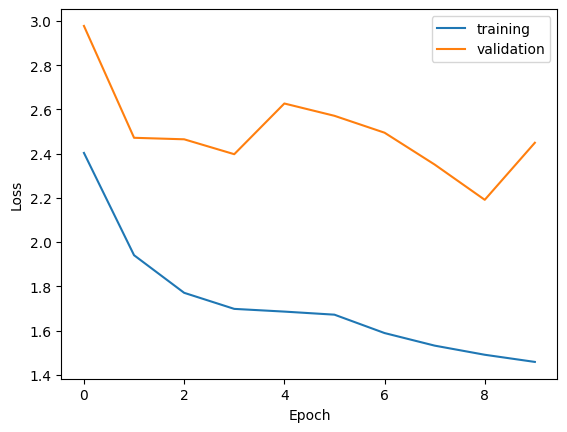

In [28]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

This model is definitely underfit. One reason is that our batch size is 1. This is a side-effect of making the number of atoms variable and then Keras/tensorflow has trouble batching together our data if there are two unknown dimensions. A standard trick is to group together multiple molecules into one graph, but making sure they are disconnected (no bonds between the molecules). That allows you to batch molecules without increasing the rank of your model/data.

Let's now check the parity plot.

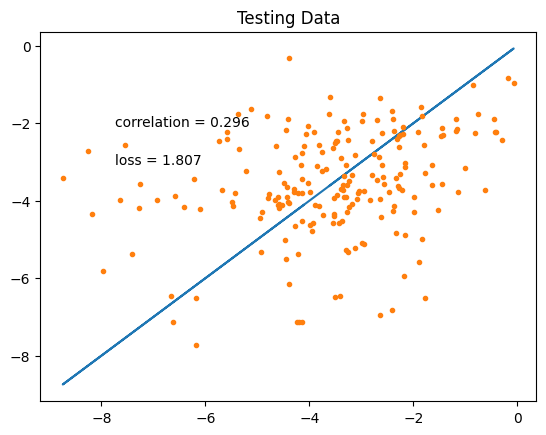

In [29]:
yhat = model.predict(test_data.batch(1), verbose=0)[:, 0]
test_y = [y for x, y in test_data]
plt.figure()
plt.plot(test_y, test_y, "-")
plt.plot(test_y, yhat, ".")
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.title("Testing Data")
plt.show()

## Message Passing Viewpoint

One way to more broadly view a GCN layer is that it is a kind of "message-passing" layer. You first compute a message coming from each neighboring node:

\begin{equation}
\vec{e}_{{s_i}j} = \vec{v}_{{s_i}j} \mathbf{W}
\end{equation}

where $v_{{s_i}j}$ means the $j$th neighbor of node $i$. The $s_i$ means senders to $i$. This is how a GCN computes the messages, it's just a weight matrix times each neighbor node features. After getting the messages that will go to node $i$, $\vec{e}_{{s_i}j}$, we aggregate them using a function which is permutation invariant to the order of neighbors:

\begin{equation}
\vec{e}_{i} = \frac{1}{|\vec{e}_{{s_i}j}|}\sum \vec{e}_{{s_i}j}
\end{equation}

In the GCN this aggregation is just a mean, but it can be any permutation invariant (possibly trainable) function. Finally, we update our node using the aggregated message in the GCN:

\begin{equation}
\vec{v}^{'}_{i} = \sigma(\vec{e}_i)
\end{equation}

where $v^{'}$ indicates the new node features. This is simply the activated aggregated message. Writing it out this way, you can see how it is possible to make small changes. One important paper by Gilmer et al. explored some of these choices and described how this general idea of message passing layers does well in learning to predict molecular energies from quantum mechanics {cite}`gilmer2017neural`. Examples of changes to the above GCN equations are to include edge information when computing the neighbor messages or use a dense neural network layer in place of $\sigma$. You can think of the GCN as one type of a broader class of message passing graph neural networks, sometimes abbreviated as MPNN.

## Gated Graph Neural Network


One common variant of the message passing layer is the **gated graph neural network** (GGN) {cite}`li2015gated`. It replaces the last equation, the node update, with

\begin{equation}
\vec{v}^{'}_{i} = \textrm{GRU}(\vec{v}_i, \vec{e}_i)
\end{equation}

where the $\textrm{GRU}(\cdot, \cdot)$ is a gated recurrent unit{cite}`chung2014empirical`. A GRU is a binary (two input arguments) neural network that is typically used in sequence modeling. The interesting property of a GGN relative to a GCN is that it has trainable parameters in the node update (from the GRU), giving the model a bit more flexibility. In a GGN, the GRU parameters are kept the same at each layer, like how a GRU is used to model sequences. What's nice about this is that you can stack infinite GGN layers without increasing the number of trainable parameters (assuming you make $\mathbf{W}$ the same at each layer). Thus GGNs are suited for large graphs, like a large protein or large unit cell.

```{margin}
You'll often see the prefix "gated" on GNNs and that means that the nodes are updated according to a GRU.
```


## Pooling

Within the message passing viewpoint, and in general for GNNS, the way that messages from neighbors are combined is a key step. This is sometimes called **pooling**, since it's similar to the pooling layer used in convolutional neural networks. Just like in pooling for convolutional neural networks, there are multiple reduction operations you can use. Typically you see a sum or mean reduction in GNNs, but you can be quite sophisticated like in the Graph Isomorphism Networks {cite}`xu2018powerful`. We'll see an example in our attention chapter of using self-attention, which can also be used for pooling. It can be tempting to focus on this step, but it's been empirically found that the choice of pooling is not so important{cite}`luzhnica2019graph,mesquita2020rethinking`. The key property of the pooling is permutation *invariance* - we want the aggregation operation to not depend on order of nodes (or edges if pooling over them). You can find a recent review of pooling methods in Grattarola et al. {cite}`grattarola2021understanding`.

You can see a more visual comparison and overview of the various pooling strategies in this distill article by Daigavane et al. {cite}`daigavane2021understanding`.

## Readout Function

GNNs output a graph by design. It is rare that our labels are graphs -- typically we have node labels or a single graph label. An example of a node label is partial charge of atoms. An example of a graph label would be the energy of the molecule. The process of converting the graph output from the GNN into our predicted node labels or graph label is called the **readout**. If we have node labels, we can simply discard the edges and use our output node feature vectors from the GNN as the prediction, perhaps with a few dense layers before our predicted output label.

If we're trying to predict a graph-level label like energy of the molecule or net charge, we need to be careful when converting from node/edge features to a graph label. If we simply put the node features into a dense layer to get to the desired shape graph label, we will lose permutation equivariance (technically it's permutation invariance now since our output is graph label, not node labels). The readout we did above in the solubility example was a reduction over the node features to get a graph feature. Then we used this graph feature in dense layers. It turns out this is the only way {cite}`zaheer2017deep` to do a graph feature readout: a reduction over nodes to get graph feature and then dense layers to get predicted graph label from those graph features. You can also do some dense layers on the node features individually, but that already happens in GNN so I do not recommend it. This readout is sometimes called DeepSets because it is the same form as the DeepSets architecture, which is a permutation invariant architecture for features that are sets{cite}`zaheer2017deep`.

You may notice that the pooling and readouts both use permutation invariant functions. Thus, DeepSets can be used for pooling and attention could be used for readouts.

### Intensive vs Extensive

One important consideration of a readout in regression is if your labels are **intensive** or **extensive**. An intensive label is one whose value is independent of the number of nodes (or atoms). For example, the index of refraction or solubility are intensive. The readout for an intensive label should (generally) be independent of the number of a nodes/atoms. So the reduction in the readout could be a mean or max, but not a sum. In contrast, an extensive label should (generally) use a sum for the reduction in the readout. An example of an extensive molecular property is enthalpy of formation.

## Chapter Summary

* Molecules can be represented by graphs by using one-hot encoded feature vectors that show the elemental identity of each node (atom) and an adjacency matrix that show immediate neighbors (bonded atoms).
* Graph neural networks are a category of deep neural networks that have graphs as inputs.
* One of the early GNNs is the Kipf & Welling GCN. The input to the GCN is the node feature vector and the adjacency matrix, and returns the updated node feature vector. The GCN is permutation invariant because it averages over the neighbors.
* A GCN can be viewed as a message-passing layer, in which we have senders and receivers. Messages are computed from neighboring nodes, which when aggregated update that node.
* A gated graph neural network is a variant of the message passing layer, for which the nodes are updated according to a gated recurrent unit function.
* The aggregation of messages is sometimes called pooling, for which there are multiple reduction operations.
* GNNs output a graph. To get a per-atom or per-molecule property, use a readout function. The readout depends on if your property is intensive vs extensive
